Project to migrate my original code for predicting the sentimment of Yelp reviews from SKlearn to PySpark.

## 1. Configure Spark

In [1]:
# import libraries for setting up spark and sql contexts
from pyspark import SparkContext, SparkConf
from pyspark.sql import DataFrameReader, SQLContext, DataFrameWriter

# import libraries for defining custom functions - udf indicates user defined function, type defines the type the function will return
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import os


# define to postgres jdbc driver path as environment variable
sparkClassPath = os.getenv('SPARK_CLASSPATH', 
                           '/Users/user/Downloads/postgresql-42.2.14.jar')

In [2]:
# define configuration settings for Spark
conf = SparkConf()
conf.setAppName('application')
conf.set('spark.jars', f'file:{sparkClassPath}')
conf.set('spark.executor.extraClassPath', sparkClassPath)
conf.set('spark.driver.extraClassPath', sparkClassPath)

# define spark context - interface between client (notebook) and cluster manager
sc = SparkContext(conf=conf)
# define sql context - entry point for spark sql functionalkty - register dataframe as tables, which you can execute SQL on
sqlContext = SQLContext(sc)

# define postgres connection parameters
url = 'postgresql://localhost:5432/user'
properties = {'user': 'user', 'password': ''}

## 2. Sample Yelp review data

In [3]:
# define user defined function for create target column
set_target_values = udf(lambda x: (x > 3)*1, IntegerType())

In [4]:
# define sampling query
def get_sample(sample_size=100):
    query = """
            with reviews_1 as (
            select review_id, stars, text
            from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75) 
            where stars = 1
            limit """ + str(sample_size) + """
            )
            , reviews_2 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 2
                limit """ + str(sample_size) + """
            )
            , reviews_4 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 4
                limit """ + str(sample_size) + """
            )
            , reviews_5 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 5
                limit """ + str(sample_size) + """
            )

            select *
            from reviews_1
            union
            select *
            from reviews_2
            union
            select *
            from reviews_4
            union
            select *
            from reviews_5 
            """
    
    # read data from postgres into a dataframe
    df = DataFrameReader(sqlContext).jdbc(url=f'jdbc:{url}', 
                                      table=f'({query}) as sample', 
                                      properties=properties)
    
    df = df.withColumn('target', set_target_values(df.stars))
    
    return df

In [130]:
yelp = get_sample(10000) 

In [131]:
yelp.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



In [132]:
yelp.show(5)

+--------------------+-----+--------------------+------+
|           review_id|stars|                text|target|
+--------------------+-----+--------------------+------+
|k9ab3LP_SakvwcBvB...|    4|i just moved here...|     1|
|y-R5xOtLRKzHyt1e1...|    1|the food is the l...|     0|
|tWgOjQCkwN5glOgWY...|    2|someone else post...|     0|
|tC9X2ZW5zM5IsiZ7y...|    5|i found this plac...|     1|
|dbOiKpr7XqhBrFxBK...|    4|nice selection of...|     1|
+--------------------+-----+--------------------+------+
only showing top 5 rows



In [133]:
yelp.describe().show()

+-------+--------------------+-----------------+-----------------------------------+------------------+
|summary|           review_id|            stars|                               text|            target|
+-------+--------------------+-----------------+-----------------------------------+------------------+
|  count|               40000|            40000|                              40000|             40000|
|   mean|                null|              3.0|                               null|               0.5|
| stddev|                null|1.581158594690159|                               null|0.5000062501171905|
|    min|--KZ04tOwwgV9Dnyx...|                1|               

okay, so i move...|                 0|
|    max|zzuuTCZLVB4osen_S...|                5|第一次去，沒有傳說中那麼神奇。
f...|                 1|
+-------+--------------------+-----------------+-----------------------------------+------------------+



In [134]:
yelp.select('stars', 'target').show(5)

+-----+------+
|stars|target|
+-----+------+
|    5|     1|
|    5|     1|
|    5|     1|
|    4|     1|
|    4|     1|
+-----+------+
only showing top 5 rows



In [135]:
yelp.groupby('stars').count().sort('stars').show()

+-----+-----+
|stars|count|
+-----+-----+
|    1|10000|
|    2|10000|
|    4|10000|
|    5|10000|
+-----+-----+



In [136]:
# create temp view which SQL Context can use to run SQL queries on
yelp.createOrReplaceTempView('sample')

In [137]:
sqlContext.sql('select avg(stars) from sample').show()

+----------+
|avg(stars)|
+----------+
|       3.0|
+----------+



## 3a. Pre-process data for modelling - Manual steps

In [138]:
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [139]:
# set review test to lowercase
yelp = yelp.withColumn('text', lower(yelp.text))

In [140]:
yelp.select('text').show(10, truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|the food and drink were good but there service ...|
|i was a fool for not coming here sooner. but i ...|
|the food was great, but the service was below a...|
|og's quality has gone way down, my nephew order...|
|it was just ok. the crab cake had a lot of brea...|
|come before they open they said. if you don't, ...|
|nice neighborhood place.  my kids love it too. ...|
|not my cup of tea.  i enjoy 'healthy' eating bu...|
|organ stop is like a trip down memory lane. our...|
|leaving  because zero is not an option! left af...|
+--------------------------------------------------+
only showing top 10 rows



In [141]:
# remove punctuation
yelp = yelp.withColumn('text', regexp_replace(yelp.text, '[^\w\s\d]+', ''))

In [142]:
yelp.select('text').show(10, truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|this place is off of 1775 north martin luther k...|
|we love this place  food is always delicious  s...|
|we came here on our anniversary when we made re...|
|the best coffee in northeast ohio the coffee ha...|
|very interesting fusion of korean and mexican c...|
|this is sad our party of 8 came in and got told...|
|authentically italianowned restaurant but the c...|
|this is my first time ever leaving a review but...|
|okay so first i mobile ordered a venti double c...|
|bugs in the coffee

my friend and i ducked in a...|
+--------------------------------------------------+
only showing top 10 rows



In [143]:
# tokenize review text
tokenizer = Tokenizer(inputCol='text', outputCol='word_tokens')

In [144]:
yelp_word_tokens = tokenizer.transform(yelp).select('review_id', 'stars', 'target', 'word_tokens')

In [145]:
yelp_word_tokens.show(5)

+--------------------+-----+------+--------------------+
|           review_id|stars|target|         word_tokens|
+--------------------+-----+------+--------------------+
|u3g6qw8QjmjBIpvjn...|    5|     1|[tequilas, is, al...|
|JLfC4sWPnVT4ltduQ...|    5|     1|[they, have, the,...|
|94d8RANZLvh3n00if...|    5|     1|[highly, recommen...|
|O9_U_9ztJgBNrIfSc...|    5|     1|[so, glad, we, tr...|
|xgiILFAPpRUkzT7Rq...|    4|     1|[, for, great, ta...|
+--------------------+-----+------+--------------------+
only showing top 5 rows



In [146]:
# remove stop words
st_remover = StopWordsRemover(inputCol='word_tokens', outputCol='words_clean', stopWords=stopwords.words('english'))

In [147]:
yelp_words_clean = st_remover.transform(yelp_word_tokens).select('review_id', 'stars', 'target', 'words_clean')

In [148]:
yelp_words_clean.show(5)

+--------------------+-----+------+--------------------+
|           review_id|stars|target|         words_clean|
+--------------------+-----+------+--------------------+
|a6OVAPU0F5nLVnMd2...|    5|     1|[family, group, s...|
|E49k0vUNryBo8MfFL...|    2|     0|[near, hotel, ope...|
|Fe_ON2Z4EqplHmDC7...|    1|     0|[sexist, show, we...|
|Nk7yfw4s430qhHLku...|    2|     0|[food, ferris, go...|
|9cMlmWbVnehG598Rq...|    5|     1|[, great, experie...|
+--------------------+-----+------+--------------------+
only showing top 5 rows



In [149]:
# stem words
stemmer = PorterStemmer()
stemmer_udf = udf(lambda tokens: [stemmer.stem(w) for w in tokens], ArrayType(StringType()))

In [150]:
yelp_stemmed = yelp_words_clean.withColumn('words_clean', stemmer_udf(yelp_words_clean.words_clean))

In [151]:
yelp_stemmed.select('words_clean').show(10, truncate=50)

+--------------------------------------------------+
|                                       words_clean|
+--------------------------------------------------+
|[omg, worth, money, know, order, , servic, grea...|
|[definit, friendliest, staff, even, christma, d...|
|[food, mediocr, servic, mediocr, overal, dine, ...|
|[decent, stop, lunch, sort, fanci, mexican, foo...|
|[open, need, someth, open, , friendli, staff, h...|
|[pepperoni, tast, stale, couldnt, believ, would...|
|[say, rip, sat, bar, order, lobster, taco, say,...|
|[snooz, lose, , place, get, pretti, pack, weeke...|
|[lose, weekend, couldnt, wait, get, vega, , tra...|
|[ive, come, place, 2, year, first, tast, korean...|
+--------------------------------------------------+
only showing top 10 rows



In [152]:
# fitler short words
remove_empty_udf = udf(lambda tokens: [w for w in tokens if len(w) > 2], ArrayType(StringType()))

In [153]:
yelp_stemmed = yelp_stemmed.withColumn('words_clean', remove_empty_udf(yelp_stemmed.words_clean))

In [154]:
yelp_stemmed.select('words_clean').show(10, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                         words_clean|
+----------------------------------------------------------------------------------------------------+
|  [cockroach, ran, across, top, tabl, meal, stale, bread, hard, enough, cut, top, mouth, meal, nice]|
|[spent, whole, day, shop, vaughn, mill, didnt, feel, like, drive, far, good, seafood, dinner, res...|
|[skip, tender, rubberi, super, salti, mash, potato, tast, like, instant, cane, way, tastier, street]|
|[bit, cavern, broken, black, forest, sandwich, keep, come, back, pretzel, bread, fab, ice, tea, g...|
|[decid, queen, review, glad, fish, macchees, green, good, daughter, fri, chicken, mash, green, be...|
|[disappoint, say, least, thought, give, place, 2nd, chanceth, first, soso, simpl, ordera, carn, a...|
|[love, place, yummi, food, also, thai, tea, boba, sure, fire, way, make,

In [155]:
from pyspark.ml.feature import NGram

In [156]:
# create ngrams = 2 col
ngrams = NGram(n=2, inputCol='words_clean', outputCol='ngrams_2')
yelp_ngrams = ngrams.transform(yelp_stemmed)

In [157]:
yelp_ngrams.show(5, truncate=50)

+----------------------+-----+------+--------------------------------------------------+--------------------------------------------------+
|             review_id|stars|target|                                       words_clean|                                          ngrams_2|
+----------------------+-----+------+--------------------------------------------------+--------------------------------------------------+
|CYySlzxUfx5yd19Vqnu8bQ|    1|     0|[order, onlin, pizza, hut, 939pm, rout, store, ...|[order onlin, onlin pizza, pizza hut, hut 939pm...|
|uSdCxwauTz5sU2GUVexlBQ|    5|     1|[nia, cashier, great, custom, servic, made, fri...|[nia cashier, cashier great, great custom, cust...|
|hrtGM6FtkRzkEGrlQq2hXg|    1|     0|[star, better, worst, italian, meal, long, whil...|[star better, better worst, worst italian, ital...|
|qc7QHEHYRroJzYZ04mRATQ|    4|     1|[crave, steam, dumpl, soup, fulfil, littl, tibe...|[crave steam, steam dumpl, dumpl soup, soup ful...|
|u6wUx6Y8qZ1ITmzdHoL

In [158]:
# merge feature columns
merge_words_udf = udf(lambda col1, col2: col1 + col2, ArrayType(StringType()))

In [159]:
yelp_merged = yelp_ngrams.withColumn('features', merge_words_udf(yelp_ngrams.words_clean, yelp_ngrams.ngrams_2)).select('target', 'features')

In [160]:
# Create CountVectorizer
cv = CountVectorizer(minDF=5, vocabSize=100000, inputCol='features', outputCol='vectors')

In [161]:
cv_model = cv.fit(yelp_merged)
yelp_cv = cv_model.transform(yelp_merged)

In [162]:
yelp_cv.show(5, truncate=100)

+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|target|                                                                                            features|                                                                                             vectors|
+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|     1|[arizona, high, expect, find, good, japanes, food, nonetheless, didnt, think, best, tast, japanes...|(75633,[0,3,10,11,20,28,29,42,52,54,64,82,135,145,155,167,179,287,823,990,991,1307,1461,1537,1695...|
|     1|[there, mani, place, eat, anymor, sinc, start, diet, perfect, quick, breakfast, lunch, spot, driv...|(75633,[0,1,25,27,35,40,42,62,85,98,117,121,131

In [163]:
# total number of words in the vocabulary
len(cv_model.vocabulary)

75633

In [164]:
# list of words in the vocabulary
sorted(cv_model.vocabulary)[:10]

['010',
 '050',
 '075',
 '099',
 '100',
 '100 better',
 '100 bill',
 '100 buck',
 '100 challeng',
 '100 degre']

In [165]:
# fit IDF
idf = IDF(inputCol='vectors', outputCol='vectors_idf')

In [166]:
yelp_idf = idf.fit(yelp_cv).transform(yelp_cv.select('target', 'vectors')).select('target', 'vectors_idf')

In [167]:
yelp_idf.show(5, truncate=100)

+------+----------------------------------------------------------------------------------------------------+
|target|                                                                                         vectors_idf|
+------+----------------------------------------------------------------------------------------------------+
|     0|(75633,[2,11,20,24,33,35,47,53,57,86,103,114,127,145,179,197,221,222,282,287,291,297,384,403,408,...|
|     1|(75633,[0,1,8,12,14,38,49,50,64,81,92,148,214,1565,2904,3334,3642,5687,5970,9349,10915,21597,2163...|
|     1|(75633,[0,7,8,35,40,42,55,59,79,90,93,126,138,155,163,172,193,208,265,375,495,505,709,748,835,873...|
|     0|(75633,[0,5,74,253,256,392,409,766,2787,3360],[0.6869913211723694,1.0798646030323313,2.3794911370...|
|     1|(75633,[3,20,46,63,101,237,1351,1508,1671,2954,3425,6210,8409,29493,74467],[1.9519987799460987,6....|
+------+----------------------------------------------------------------------------------------------------+
only showi

## 3b. Pre-process data for modelling - Pipeline

I could not easily create a pipeline for the above steps (3a.) as all the pre-processing stages require fit/transnform steps. I have two options for creating a pipeline:

- write a class for doing pre-processing for those steps which lack a tranform method
- re-write my code to allow for using methods which support .transform()

I will leave this for now and move to model creation.

## 4. Model Creation

In [168]:
import numpy as np
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from time import time
import statistics

In [169]:
# split data into training and test sets
data_train, data_test = yelp_idf.randomSplit([0.8, 0.2], seed=1)

In [170]:
# check sampling weights for target in training set
data_train.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|15966|
|     0|16016|
+------+-----+



In [171]:
# check sampling weights for target in testing set
data_test.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 4034|
|     0| 3984|
+------+-----+



In [172]:
# setup models and parameters for gridsearching
nb = NaiveBayes(featuresCol='vectors_idf',labelCol='target')
lr = LogisticRegression(featuresCol='vectors_idf',labelCol='target')


models = {
    'Naive Bayes': (nb, 
                     ParamGridBuilder() \
                     .addGrid(nb.modelType, ['multinomial']) \
                     .build()),
    'Logistic Regression': (lr, 
                            ParamGridBuilder() \
                            .addGrid(lr.regParam, np.logspace(1, 5, 5)) \
                            .addGrid(lr.fitIntercept, [True]) \
                            .build())    
}

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='target', metricName='areaUnderROC')

In [173]:
# Gridsearch models to find best parameters - print out results for test set based on best parameters
for key, value in models.items():
    print('Model: ', key)
    crossval = CrossValidator(estimator=value[0], estimatorParamMaps=value[1], evaluator=evaluator, numFolds=5)
    
    t0 = time()
    model_fit = crossval.fit(data_train)
    train_time = time() - t0
    print(("Train time: %0.3fs" % train_time))
    
    # find the best model parameters
    java_model = model_fit.bestModel._java_obj
    print('Best model parameters:', {param.name: java_model.getOrDefault(java_model.getParam(param.name)) for param in value[1][0]})
    
    # get average CV score for chosen metric
    print('Avg. CV Area Under ROC: ', np.round(statistics.mean(model_fit.avgMetrics),3))
    
    # get predictions for test set
    pred_test = model_fit.transform(data_test)
    test_target = [int(row['target']) for row in pred_test.collect()]
    test_pred = [int(row['prediction']) for row in pred_test.collect()]

    print('Test Area Under ROC: ', np.round(evaluator.evaluate(pred_test),3))
    print("Test accuracy : ", np.round(accuracy_score(test_target, test_pred),3))

    print('\nconfusion matrix: ')
    print(confusion_matrix(test_target, test_pred))
    print('\n')
    print(classification_report(test_target, test_pred))
    print('-' * 60)

Model:  Naive Bayes
Train time: 1249.488s
Best model parameters: {'modelType': 'multinomial'}
Avg. CV Area Under ROC:  0.907
Test Area Under ROC:  0.907
Test accuracy :  0.916

confusion matrix: 
[[3611  373]
 [ 303 3731]]


              precision    recall  f1-score   support

           0       0.92      0.91      0.91      3984
           1       0.91      0.92      0.92      4034

    accuracy                           0.92      8018
   macro avg       0.92      0.92      0.92      8018
weighted avg       0.92      0.92      0.92      8018

------------------------------------------------------------
Model:  Logistic Regression
Train time: 1278.225s
Best model parameters: {'regParam': 10.0, 'fitIntercept': True}
Avg. CV Area Under ROC:  0.723
Test Area Under ROC:  0.897
Test accuracy :  0.899

confusion matrix: 
[[3380  604]
 [ 204 3830]]


              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3984
           1       0.86      0.95

In [174]:
# assign optimal LR parameters
lr.setRegParam = 10.0
lr.setFitIntercept = True

lr_model = lr.fit(data_test)

In [175]:
model_summary = lr_model.summary

In [176]:
model_summary.areaUnderROC

0.9474558185642918

In [177]:
model_summary.predictions.select('target', 'probability', 'prediction').show(10, truncate=False)

+------+-------------------------------------------+----------+
|target|probability                                |prediction|
+------+-------------------------------------------+----------+
|0.0   |[1.0,5.785826511047977E-28]                |0.0       |
|0.0   |[1.0,6.7197655027074085E-37]               |0.0       |
|0.0   |[1.0,4.176239747076922E-26]                |0.0       |
|0.0   |[0.9999999991562316,8.43768448826338E-10]  |0.0       |
|0.0   |[0.9999999999999878,1.2186428684338308E-14]|0.0       |
|0.0   |[1.4898727475853024E-9,0.9999999985101273] |1.0       |
|0.0   |[0.9999999999980567,1.943246850557438E-12] |0.0       |
|0.0   |[1.0,1.3291262887896124E-19]               |0.0       |
|0.0   |[0.9997675149098847,2.3248509011532904E-4] |0.0       |
|0.0   |[0.9996725767215732,3.274232784267846E-4]  |0.0       |
+------+-------------------------------------------+----------+
only showing top 10 rows



In [178]:
import matplotlib.pyplot as plt

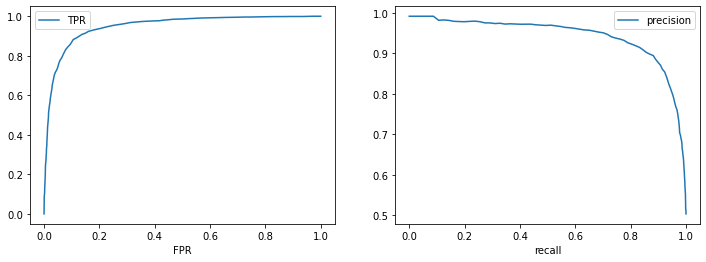

In [179]:
# create AUC & PR curves for chosen model
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
model_summary.roc.toPandas().plot(x='FPR', y='TPR', ax=ax[0])
model_summary.pr.toPandas().plot(x='recall', y='precision', ax=ax[1])
plt.show()

In [ ]:
# stop spark cluster
sc.stop()